In [1]:
GPU = True  #set to True to use GPU for XGboost 
OPTUNA = True #set to True to run Optuna first, false to use saved hyperparameters
#MODEL_NAME = "xgboost"
MODEL_NAME = "lightgbm"

## Model Testing

Runs Gradient-Boosted Tree (gbt) training models (option to select Xgboost or Lightgbm) and logs the key information to Neptune.ai. 

(Originally 2 notebooks were utilized, one for XGB and one for LGB, but these were converted to this single notebook for convenience. Simple "if" statements are used to select the small differences in code when choosing one or the other.)

If Optuna is set to True, then hyperparameters are tuned first and used for the test run. Otherwise, the current best hyperameters are kept in a JSON file and are utilized instead. If Optuna is utilized, then a separate Neptune logging run is initialized to record the key tuning data.

Various metrics are calculated and recorded. AUC will likely be of primary interest since the eventual goal is to compare win-lose probablilities against betting odds, not necessarily to accuractely predict the winner for each game. Accuracy is an interesting metric though, and is recorded as well.

Along with standard built-in measures for feature importance using weight and gain, Shapley value feature importances are also generated to give a different perspective on feature importances. These Shapley feature importances are local to the specific data run through the model and therefore can be used in some form of adversarial evaluation, such as train data vs test data and/or test split 1 vs test split 2 (see below.)

This model evaluation does include splitting the test set into "early" season data (Test1) and "later" season data (Test2) and comparing the performance on each.

Process flow:

- load data that has gone through feature engineering and selection
- intialize Neptune.ai logging run
- set key options
- fix datatypes for correct date format and decrease memory footprint
- perform any categorical encoding required for XGB or LGB
- drop any features that are not useful and set the target
- load hyperparameters from JSON file or re-tune them with Optuna
- train the model with stratified K-fold cross validation
- ouput key metrics and feature importances for Out-of-Fold validation set
- run the model on the test/validation set
- ouput key metrics and feature importances for test/validation data
- split the test/validation data into Test1 (early season) and Test2 (later season)
- run model on each
- ouput key metrics and feature importances for each
- perform model evaluation, comparing train vs test and test1 vs test2
- if re-tuned hyperparameters are better (per human inspection) then manually run the function to save these as new defaults. (These re-tuned hyperparameters are always logged at Neptune.ai and can be retrieved whenever necessary, but human interaction is required to establish new default parameters because various experiments might not be optimal in the long run.)



In [2]:
import os

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

from sklearn.model_selection import (
    StratifiedKFold, 
    TimeSeriesSplit,
)

import xgboost as xgb
print('XGB version:', xgb.__version__)

import lightgbm as lgb
from lightgbm import (
    early_stopping,
    log_evaluation,
)
print('LGB version:', lgb.__version__)

import optuna
from optuna.visualization import (
    plot_optimization_history, 
    plot_param_importances,
)

from src.optuna_objectives import (
    XGB_objective,
    LGB_objective,
)

import neptune.new as neptune
from neptune.new.integrations.xgboost import NeptuneCallback
from neptune.new.integrations.lightgbm import (
    NeptuneCallback as LGB_NeptuneCallback, 
    create_booster_summary,
)

import neptune.new.integrations.optuna as optuna_utils
from neptune.new.types import File

from tqdm import tqdm

import shap

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from src.common_functions import (
    plot_confusion_matrix,
    run_sweetviz_comparison,
)

from pathlib import Path  #for Windows/Linux compatibility
DATAPATH = Path(r'data')

import ipynbname

import json

import warnings
warnings.simplefilter('ignore')


XGB version: 1.6.2
LGB version: 3.3.3


In [3]:
TRAIN_NAME = "train_selected.csv"
TEST_NAME = "test_selected.csv"

train = pd.read_csv(DATAPATH / TRAIN_NAME)
test = pd.read_csv(DATAPATH / TEST_NAME)


**Setup Neptuna.ai experiment tracking**

In [4]:
LOGGING_NOTE = "pipeline test"

try:
    NEPTUNE_API_TOKEN = os.environ['NEPTUNE_API_TOKEN']
except:
    raise Exception('Set environment variable NEPTUNE_API_TOKEN')
    
PROJECT = "cmunch1/nba-prediction"
PROJECT_OPTUNA = "cmunch1/nba-optuna" #for 2nd run if hyperparameters are tuned
SOURCE = ipynbname.name() + ".ipynb"
SOURCE_SPLIT = "03_train_test_split.ipynb"
SOURCE_ENG = "05_feature_engineering.ipynb"
SOURCE_SEL = "06_feature_selection.ipynb"


run = neptune.init(
    project=PROJECT,
    source_files=[SOURCE,SOURCE_SPLIT,SOURCE_ENG,SOURCE_SEL],
    api_token=NEPTUNE_API_TOKEN,
)
if MODEL_NAME == "xgboost":
    neptune_callback = NeptuneCallback(run=run)
if MODEL_NAME == "lightgbm":
    neptune_callback = LGB_NeptuneCallback(run=run)

run["note"] = LOGGING_NOTE
run["sys/tags"].add([MODEL_NAME,])
run['dataset/train'] = TRAIN_NAME
run['dataset/test'] = TEST_NAME

https://app.neptune.ai/cmunch1/nba-prediction/e/NBAP-77
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


**Options**

In [5]:
run["model/parameters/GPU"] = GPU
run["model/parameters/OPTUNA"] = OPTUNA

if OPTUNA:
    run["model/optuna/optuna_cv"] = OPTUNA_CV = "TimeSeriesSplit"
    #run["model/parameters/optuna_cv"] = OPTUNA_CV = "StratifiedKFold"    
    run["model/optuna/optuna_folds"] = OPTUNA_FOLDS = 5
    run["model/optuna/optuna_trials"] = OPTUNA_TRIALS = 250

run["model/parameters/k_folds"] = K_FOLDS = 5
run["model/parameters/seed"] = SEED = 13
run["model/parameters/num_boost_round"] = NUM_BOOST_ROUND = 2000
run["model/parameters/enable_categorical"] = ENABLE_CATEGORICAL = False
run["model/parameters/early_stopping"] = EARLY_STOPPING = 200 

VERBOSITY = 0
LOG_EVALUATION = 100 #lightgbm display parameter

if MODEL_NAME == "xgboost":

    BASE_MODEL = xgb
    
    STATIC_PARAMS = {
                    'seed': SEED,
                    'eval_metric': 'auc',
                    "objective": "binary:logistic",
                    'verbosity': VERBOSITY,
                    }

    GPU_PARAMS = {
                 'tree_method': 'gpu_hist',
                 'predictor': 'gpu_predictor',
                 }
    
if MODEL_NAME == "lightgbm":
    
    BASE_MODEL = lgb
    
    STATIC_PARAMS = {
                    'seed': SEED,
                    'verbosity': -1,           
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc', 
                    }

    GPU_PARAMS = {
                'device': 'gpu',
                'gpu_platform_id': 0,
                'gpu_device_id': 0,
                 }

if GPU:
    STATIC_PARAMS = STATIC_PARAMS | GPU_PARAMS


**Fix Datatypes for smaller memory footprint**

In [6]:
def fix_datatypes(df):
    df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST'])

    long_integer_fields = ['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON']

    #convert long integer fields to int32 from int64
    for field in long_integer_fields:
        df[field] = df[field].astype('int32')
    
    #convert the remaining int64s to int8
    for field in df.select_dtypes(include=['int64']).columns.tolist():
        df[field] = df[field].astype('int8')
        
    #convert float64s to float16s
    for field in df.select_dtypes(include=['float64']).columns.tolist():
        df[field] = df[field].astype('float16')
        
    return df

train = fix_datatypes(train)
test = fix_datatypes(test)


**Encode categoricals**

In [7]:
category_columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', ]

In [8]:
# To use special category feature capabalities in XGB and LGB, categoricals must be ints from 0 to N-1
# Conversion can be accomplished by simple subtraction for several features
# (these capabilities may or may not be used, but encoding does not hurt anything)

def encode_categoricals(df):
    first_team_ID = df['HOME_TEAM_ID'].min()
    first_season = df['SEASON'].min()
    
    df['HOME_TEAM_ID'] = (df['HOME_TEAM_ID'] - first_team_ID).astype('int8')
    df['VISITOR_TEAM_ID'] = (df['VISITOR_TEAM_ID'] - first_team_ID).astype('int8')
    df['SEASON'] = (df['SEASON'] - first_season).astype('int8')
     
    if MODEL_NAME == "xgboost":
        if ENABLE_CATEGORICAL:
            for field in category_columns:
                df[field] = df[field].astype('category')

    return df

train = encode_categoricals(train)
test = encode_categoricals(test)



**Drop Features**

In [9]:
target = train['TARGET']
test_target = test['TARGET']

all_columns = train.columns.tolist()
drop_columns = ['TARGET', 'GAME_DATE_EST', 'GAME_ID', ] 
long_stats_x = [ 'G_x', 'W_x', 'L_x', 'W_PCT_x', 'HOME_W_x', 'HOME_L_x', 'HOME_W_PCT_x' , 'ROAD_W_x' , 'ROAD_L_x', 'ROAD_W_PCT_x']  
long_stats_y = [ 'G_y', 'W_y', 'L_y', 'W_PCT_y', 'HOME_W_y', 'HOME_L_y', 'HOME_W_PCT_y' , 'ROAD_W_y' , 'ROAD_L_y', 'ROAD_W_PCT_y'] 

drop_columns = drop_columns + long_stats_x 
drop_columns = drop_columns + long_stats_y 


use_columns = [item for item in all_columns if item not in drop_columns]

#use_columns = [item for item in use_columns if "LEAGUE" in item]


train = train[use_columns]
test = test[use_columns]

run["model/features"].log(use_columns)


### Optuna Hyperparameter Tuning

If OPTUNA is set to true, this testing run will first tune new hyperparameters and use these for training

In [10]:
def run_optuna():
    
    #log separate Neptune run for optuna hyperameter tuning
    run2 = neptune.init(
                    project=PROJECT_OPTUNA,
                    source_files=[SOURCE,SOURCE_SPLIT,SOURCE_ENG,SOURCE_SEL],
                    api_token=NEPTUNE_API_TOKEN,
                    )
    run2["options/optuna_cv"] = OPTUNA_CV 
    run2["options/optuna_folds"] = OPTUNA_FOLDS 
    run2["options/optuna_trials"] = OPTUNA_TRIALS 
    run2["options/GPU"] = GPU
    run2["options/enable_categorical"] = ENABLE_CATEGORICAL
    run2["features"].log(use_columns)
    run2["sys/tags"].add([MODEL_NAME,])
    
    if MODEL_NAME == "xgboost":
        func = lambda trial: XGB_objective(trial, train, target, STATIC_PARAMS, ENABLE_CATEGORICAL, NUM_BOOST_ROUND, OPTUNA_CV, OPTUNA_FOLDS, SEED)
    if MODEL_NAME == "lightgbm":
        func = lambda trial: LGB_objective(trial, train, target, category_columns, STATIC_PARAMS, ENABLE_CATEGORICAL, NUM_BOOST_ROUND, OPTUNA_CV, OPTUNA_FOLDS, SEED, EARLY_STOPPING)         
    
    study = optuna.create_study(direction='maximize')
    study.optimize(func, n_trials = OPTUNA_TRIALS,)

    optuna_utils.log_study_metadata(study, run2)
    
    print("Study Best Value:",study.best_value)
    print("Study Best Params:",study.best_params)
    
    plot_optimization_history(study)
    
    plot_param_importances(study)
    
    run2["best_value"] = study.best_value
    run2["best_params"] = study.best_params
    run2["static_params"] = STATIC_PARAMS
    
    run2.stop()
    
    return study.best_params
    
    

**Set Hyperparameters**

Run OPTUNA or load best parameters saved in JSON file.

In [11]:
if OPTUNA:
    tuned_params = run_optuna()
else:
    with open(MODEL_NAME + '.json') as f:
        tuned_params = json.loads(f.read())

model_params= STATIC_PARAMS | tuned_params

run["model/params"] = model_params
    

https://app.neptune.ai/cmunch1/nba-optuna/e/NBAOPT-16
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


[I 2022-11-12 10:55:35,172] A new study created in memory with name: no-name-c664924a-e922-4c14-8766-335ce128714c
[I 2022-11-12 10:55:43,472] Trial 0 finished with value: 0.5925562144359211 and parameters: {'lambda_l1': 0.14379949041231938, 'lambda_l2': 0.001042371095087456, 'learning_rate': 0.00033181013718116886, 'max_depth': 20, 'n_estimators': 109204, 'feature_fraction': 0.7445132394621625, 'bagging_fraction': 0.6445978631238536, 'bagging_freq': 4, 'num_leaves': 625, 'min_child_samples': 254, 'min_data_per_groups': 10}. Best is trial 0 with value: 0.5925562144359211.
[I 2022-11-12 10:55:49,811] Trial 1 finished with value: 0.6097320466420767 and parameters: {'lambda_l1': 0.00010657232871213527, 'lambda_l2': 4.5156741914639476e-08, 'learning_rate': 0.1952491568256493, 'max_depth': 40, 'n_estimators': 58827, 'feature_fraction': 0.8760358035644978, 'bagging_fraction': 0.6115870511237361, 'bagging_freq': 3, 'num_leaves': 883, 'min_child_samples': 188, 'min_data_per_groups': 64}. Best i

Study Best Value: 0.6250325861345821
Study Best Params: {'lambda_l1': 0.014353286456597142, 'lambda_l2': 1.8797714715567863e-05, 'learning_rate': 0.0074219704795943425, 'max_depth': 5, 'n_estimators': 8165, 'feature_fraction': 0.7165888165225329, 'bagging_fraction': 0.41679785470194425, 'bagging_freq': 5, 'num_leaves': 965, 'min_child_samples': 94, 'min_data_per_groups': 89}
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 39 operations to synchronize with Neptune. Do not kill this process.
All 39 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/cmunch1/nba-optuna/e/NBAOPT-16


**Setup Results table**

Store key metrics for easy review at the bottom of the notebook

In [12]:
results = pd.DataFrame() #record metrics for easy comparison at the end

#Load Simple Model results for later comparison
def SimpleModel(test, true):

    #predict = test['TEAM1_win_AVG_LAST_40_ALL_x'].apply(lambda x: 0 if x < 0.50 else 1)
    #predict = test['HOME_W_PCT_x'].apply(lambda x: 0 if x < 0.50 else 1)
    predict = np.ones((test.shape[0],)) #set all predictions to 1 (home team wins)
    acc_score = accuracy_score(true, predict)
    auc_score = roc_auc_score(true, predict)
    
    return acc_score , auc_score

acc_score , auc_score = SimpleModel(test, test_target)
df = {'Label': 'Simple Model', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
results = results.append(df, ignore_index = True) 


### Train

**Support functions**

In [13]:
def get_scores(target, preds):
    #for accuracy score, prediction probabilities must be convert to binary scores (Win or Lose)
    #determine optimum threshold for conveting probablities using ROC curve
    #generally 0.5 works for balanced data
    #fpr = false positive rate, tpr = true postive rate
    
    fpr, tpr, thresholds = roc_curve(target,preds)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    preds_binary = (preds > optimal_threshold).astype(int)
    
    acc_score = accuracy_score(target, preds_binary)
    auc_score = roc_auc_score(target, preds)

    print()
    print("Scores:")
    print()
    print("Accuracy Score:", acc_score)
    print("AUC Score:", auc_score)
    print("Optimal Threshold:", optimal_threshold)
    
    return preds_binary, acc_score, auc_score, optimal_threshold

In [14]:
def get_shapley(MODEL_NAME, model, data):
    if MODEL_NAME == "xgboost":
        shap = model.predict(data, pred_contribs=True)
    if MODEL_NAME == "lightgbm":
        shap = model.predict(data, pred_contrib=True)
        
    return shap

def get_shapley_interactions(MODEL_NAME, model, data):
    if MODEL_NAME == "xgboost":
        shap_interactions = model.predict(data, pred_interactions=True)
    if MODEL_NAME == "lightgbm": #not currently supported
        shap_interactions = np.zeros((data.shape[0],data.shape[1]+1,data.shape[1]+1))
    
    return shap_interactions
        

**Training with K-Fold Cross Validation**

Shapley values are also generated using built-in functionality of XGB and LGB. This enables a different approach to determining feature importances, and because this is a local determination to the given dataset, it can be used for advesarial evaluation of train data vs test data.

In [15]:
%%time

#initialize oof arrays including Shapley values and Shapley interaction values
train_oof = np.zeros((train.shape[0],))
train_oof_shap = np.zeros((train.shape[0],train.shape[1]+1))
train_oof_shap_interact = np.zeros((train.shape[0],train.shape[1]+1,train.shape[1]+1))

   
# K-fold cross validation

kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
    
    train_df, val_df = train.iloc[train_ind], train.iloc[val_ind]
    train_target, val_target = target[train_ind], target[val_ind]

    if MODEL_NAME == "xgboost":
        train_dmatrix = xgb.DMatrix(train_df, label=train_target,enable_categorical=ENABLE_CATEGORICAL)
        val_dmatrix = xgb.DMatrix(val_df, label=val_target,enable_categorical=ENABLE_CATEGORICAL)
        val_data = val_dmatrix
       
        model =  xgb.train(model_params, 
                           train_dmatrix, 
                           num_boost_round = NUM_BOOST_ROUND,
                          callbacks=[neptune_callback],
                          )
    
    if MODEL_NAME == "lightgbm":
        train_lgbdataset = lgb.Dataset(train_df, label=train_target, categorical_feature=category_columns)
        val_lgbdataset = lgb.Dataset(val_df, label=val_target, reference = train_lgbdataset, categorical_feature=category_columns)
        val_data = val_df
        
        model =  lgb.train(model_params, 
                       train_lgbdataset,
                       valid_sets=val_lgbdataset,
                       #num_boost_round = NUM_BOOST_ROUND,
                       callbacks=[log_evaluation(LOG_EVALUATION),
                                  early_stopping(EARLY_STOPPING,verbose=False),
                                  neptune_callback],
                       #verbose_eval= VERBOSE_EVAL,
                      )
    
    temp_oof = model.predict(val_data)
    temp_oof_shap = get_shapley(MODEL_NAME, model, val_data)
    temp_oof_shap_interact = get_shapley_interactions(MODEL_NAME, model, val_data)

    train_oof[val_ind] = temp_oof

    train_oof_shap[val_ind, :] = temp_oof_shap
    train_oof_shap_interact[val_ind, :,:] = temp_oof_shap_interact
    
    temp_oof_binary, acc_score, auc_score, optimal_threshold = get_scores(val_target, temp_oof)

# Out-of-Fold composite for train data

train_oof_binary, acc_score, auc_score, optimal_threshold = get_scores(target,train_oof)

run["train/accuracy"] = acc_score 
run["train/AUC"] = auc_score 
run["train/optimal_threshold"] = optimal_threshold

df = {'Label': 'Train', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':optimal_threshold}
results = results.append(df, ignore_index = True)            

0it [00:00, ?it/s]

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[100]	valid_0's auc: 0.689227
[200]	valid_0's auc: 0.691469
[300]	valid_0's auc: 0.691946
[400]	valid_0's auc: 0.692321
[500]	valid_0's auc: 0.692666
[600]	valid_0's auc: 0.692505
[700]	valid_0's auc: 0.69259
[800]	valid_0's auc: 0.69272
[900]	valid_0's auc: 0.692588


1it [00:05,  5.07s/it]


Scores:

Accuracy Score: 0.6450789229340761
AUC Score: 0.6929013600630071
Optimal Threshold: 0.5803512027783443
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[100]	valid_0's auc: 0.695891
[200]	valid_0's auc: 0.697725
[300]	valid_0's auc: 0.697242


2it [00:07,  3.69s/it]


Scores:

Accuracy Score: 0.6504178272980501
AUC Score: 0.6978852670381086
Optimal Threshold: 0.5881291659725905
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 0.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 1.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 2.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 3.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 4.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 5.0
Error occurred during asynchronous opera

[100]	valid_0's auc: 0.681701


Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 154.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 155.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 156.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 157.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 158.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 159.0
Error occurred during asynch

[200]	valid_0's auc: 0.683098


Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 188.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 189.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 190.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 191.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 192.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 193.0
Error occurred during asynch

[300]	valid_0's auc: 0.683174


Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 239.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 240.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 241.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 242.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 243.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 244.0
Error occurred during asynch

[400]	valid_0's auc: 0.682268


Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 345.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 346.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 347.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 348.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 349.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 350.0
Error occurred during asynch

[500]	valid_0's auc: 0.681734


Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 468.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 469.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 470.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 471.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 472.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 473.0
Error occurred during asynch


Scores:

Accuracy Score: 0.6433712560947296
AUC Score: 0.6834708901781514
Optimal Threshold: 0.5698352722560637
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[100]	valid_0's auc: 0.689392
[200]	valid_0's auc: 0.691055
[300]	valid_0's auc: 0.69221
[400]	valid_0's auc: 0.692973
[500]	valid_0's auc: 0.6926


Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 0.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 1.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 2.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 3.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 4.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 5.0
Error occurred during asynchronous opera

[600]	valid_0's auc: 0.692493


Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 383.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 384.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 385.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 386.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 387.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 388.0
Error occurred during asynch


Scores:

Accuracy Score: 0.6417459948920362
AUC Score: 0.6932599746357512
Optimal Threshold: 0.5900138626508244
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[100]	valid_0's auc: 0.689205
[200]	valid_0's auc: 0.689705
[300]	valid_0's auc: 0.689803


5it [00:18,  3.63s/it]


Scores:

Accuracy Score: 0.6512653819363826
AUC Score: 0.6904420467032049
Optimal Threshold: 0.5684999297386862

Scores:

Accuracy Score: 0.6495797929145192
AUC Score: 0.6886298595368463
Optimal Threshold: 0.5694470869196491
CPU times: total: 4min 16s
Wall time: 18.2 s


In [16]:
train

,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,MONTH,HOME_TEAM_WIN_STREAK,HOME_TEAM_WINS_AVG_LAST_3_HOME,HOME_TEAM_WINS_AVG_LAST_7_HOME,HOME_TEAM_WINS_AVG_LAST_10_HOME,HOME_PTS_home_AVG_LAST_3_HOME,HOME_PTS_home_AVG_LAST_7_HOME,HOME_PTS_home_AVG_LAST_10_HOME,HOME_FG_PCT_home_AVG_LAST_3_HOME,HOME_FG_PCT_home_AVG_LAST_7_HOME,HOME_FG_PCT_home_AVG_LAST_10_HOME,HOME_FT_PCT_home_AVG_LAST_3_HOME,HOME_FT_PCT_home_AVG_LAST_7_HOME,HOME_FT_PCT_home_AVG_LAST_10_HOME,HOME_FG3_PCT_home_AVG_LAST_3_HOME,HOME_FG3_PCT_home_AVG_LAST_7_HOME,HOME_FG3_PCT_home_AVG_LAST_10_HOME,HOME_AST_home_AVG_LAST_3_HOME,HOME_AST_home_AVG_LAST_7_HOME,HOME_AST_home_AVG_LAST_10_HOME,HOME_REB_home_AVG_LAST_3_HOME,HOME_REB_home_AVG_LAST_7_HOME,HOME_REB_home_AVG_LAST_10_HOME,HOME_PTS_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_PTS_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_PTS_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_FG_PCT_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_FG_PCT_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_FG_PCT_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_FT_PCT_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_FT_PCT_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_FT_PCT_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_FG3_PCT_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_FG3_PCT_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_FG3_PCT_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_AST_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_AST_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_AST_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_REB_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_REB_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_REB_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,VISITOR_TEAM_WIN_STREAK,VISITOR_TEAM_WINS_AVG_LAST_3_VISITOR,VISITOR_TEAM_WINS_AVG_LAST_7_VISITOR,VISITOR_TEAM_WINS_AVG_LAST_10_VISITOR,VISITOR_PTS_away_AVG_LAST_3_VISITOR,VISITOR_PTS_away_AVG_LAST_7_VISITOR,VISITOR_PTS_away_AVG_LAST_10_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_3_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_7_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_10_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_3_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_7_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_10_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_3_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_7_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_10_VISITOR,VISITOR_AST_away_AVG_LAST_3_VISITOR,VISITOR_AST_away_AVG_LAST_7_VISITOR,VISITOR_AST_away_AVG_LAST_10_VISITOR,VISITOR_REB_away_AVG_LAST_3_VISITOR,VISITOR_REB_away_AVG_LAST_7_VISITOR,VISITOR_REB_away_AVG_LAST_10_VISITOR,VISITOR_TEAM_WINS_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_TEAM_WINS_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_TEAM_WINS_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_PTS_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_PTS_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_PTS_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG_PCT_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG_PCT_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG_PCT_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FT_PCT_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FT_PCT_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FT_PCT_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG3_PCT_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG3_PCT_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG3_PCT_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_AST_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_AST_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_AST_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_REB_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_REB_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_REB_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,MATCHUP_WINPCT_3_x,MATCHUP_WINPCT_7_x,MATCHUP_WINPCT_10_x,MATCHUP_WIN_STREAK_x,WIN_STREAK_x,HOME_AWAY_STREAK_x,TEAM1_win_AVG_LAST_3_ALL_x,TEAM1_win_AVG_LAST_7_ALL_x,TEAM1_win_AVG_LAST_10_ALL_x,TEAM1_win_AVG_LAST_15_ALL_x,PTS_AVG_LAST_3_ALL_x,PTS_AVG_LAST_7_ALL_x,PTS_AVG_LAST_10_ALL_x,PTS_AVG_LAST_15_ALL_x,FG_PCT_AVG_LAST_3_ALL_x,FG_PCT_AVG_LAST_7_ALL_x,FG_PCT_AVG_LAST_10_ALL_x,FG_PCT_AVG_LAST_15_ALL_x,FT_PCT

**OOF Confusion Matrix**

[[5172 3654]
 [3893 8818]]


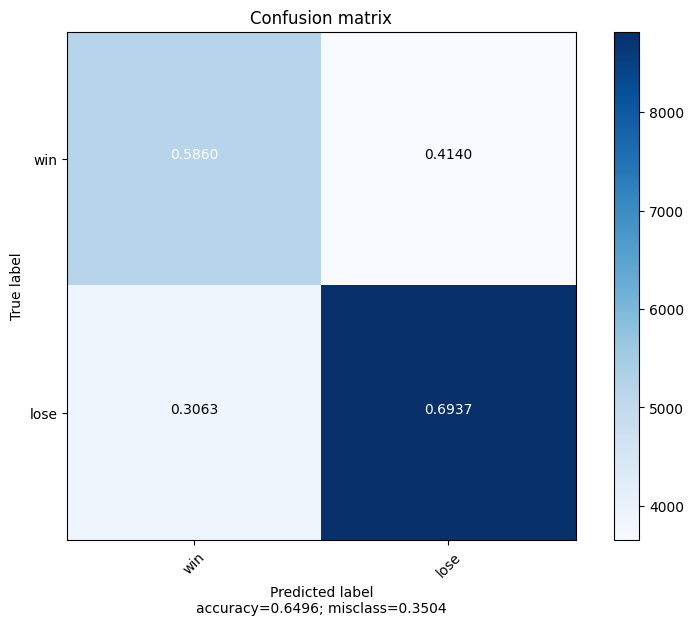

In [17]:
cm = confusion_matrix(target, train_oof_binary)
print(cm)
fig = plot_confusion_matrix(cm,['win','lose'])
run["train/confusion_matrix"].upload(fig)


**OOF Classification report**

In [18]:
run["train/classification_report"] = classification_report(target, train_oof_binary)
print(classification_report(target, train_oof_binary))

              precision    recall  f1-score   support

           0       0.57      0.59      0.58      8826
           1       0.71      0.69      0.70     12711

    accuracy                           0.65     21537
   macro avg       0.64      0.64      0.64     21537
weighted avg       0.65      0.65      0.65     21537



**Train Feature Importance via Weight/Splits - the number of times a feature appears in a tree**

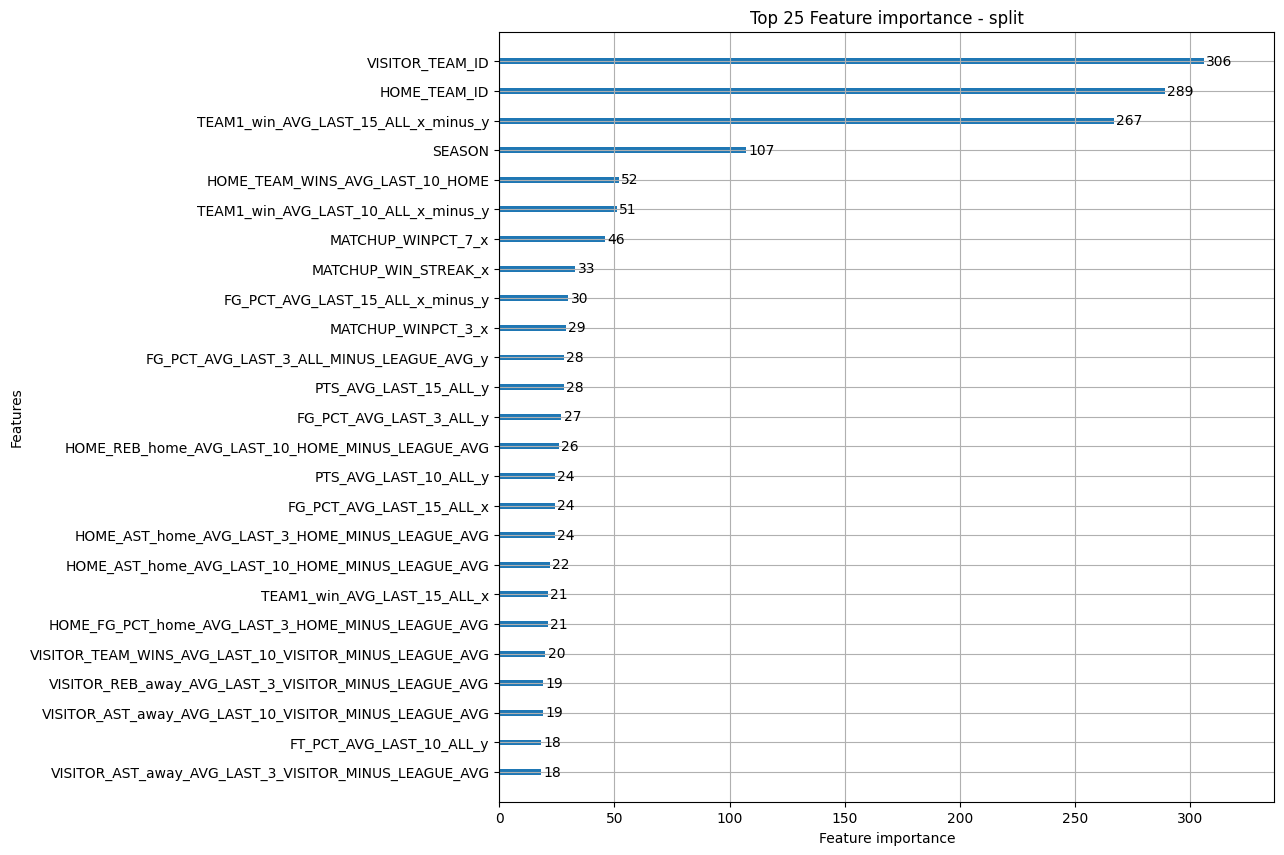

In [19]:
if MODEL_NAME == "xgboost":
    IMPORTANCE_TYPE = 'weight'
if MODEL_NAME == "lightgbm":
    IMPORTANCE_TYPE = 'split'

max_features = 25
max_title = 'Top ' + str(max_features) + ' Feature importance - ' + IMPORTANCE_TYPE
fig, ax = plt.subplots(1,1,figsize=(10,10))
BASE_MODEL.plot_importance(model, importance_type=IMPORTANCE_TYPE, max_num_features=max_features, title=max_title ,ax=ax)
run["train/feature_importance_" + IMPORTANCE_TYPE].upload(fig)

**Train Feature Importance via Gain - the average gain of splits which use the feature**

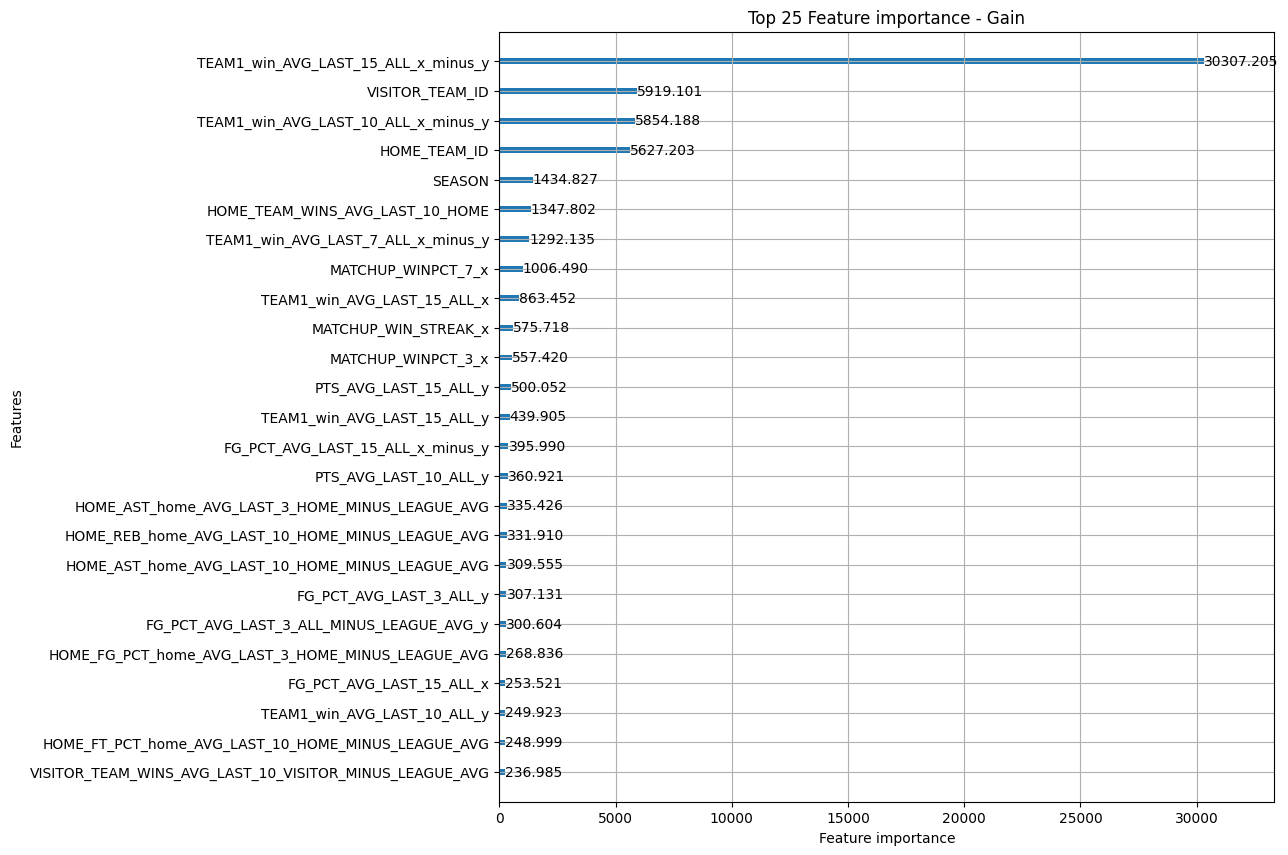

In [20]:
max_features = 25
max_title = 'Top ' + str(max_features) + ' Feature importance - Gain'
fig, ax = plt.subplots(1,1,figsize=(10,10))
BASE_MODEL.plot_importance(model, importance_type='gain', max_num_features=max_features, title=max_title ,ax=ax)
run["train/feature_importance_gain"].upload(fig)

**OOF Feature Importance via Shapley values**

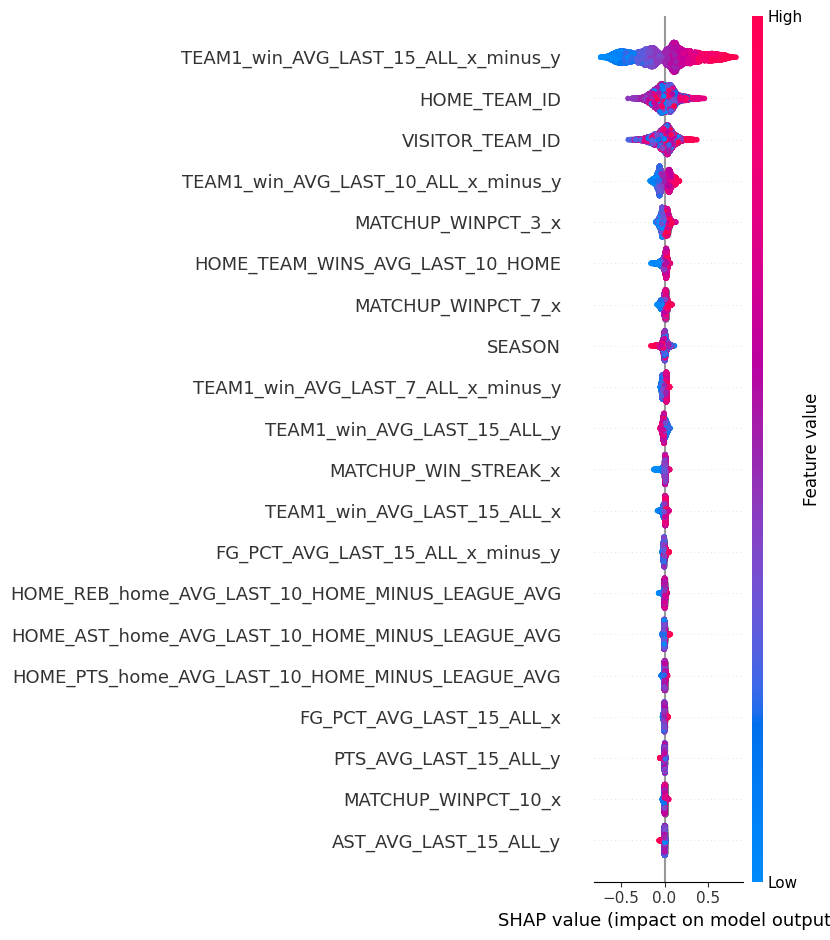

In [21]:
# summarize the effects of all the features
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(train_oof_shap[:,:-1], train)
run["train/shapley_summary"].upload(fig)

Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 0.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 1.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 2.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 3.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 4.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 5.0
Error occurred during asynchronous opera

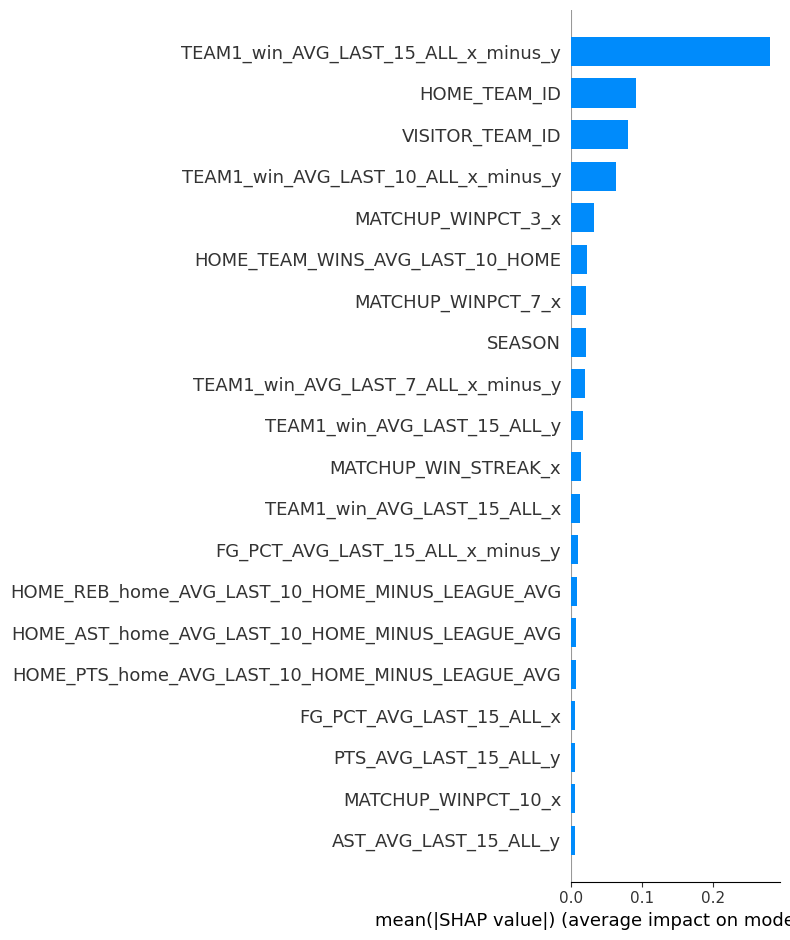

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar")
run["train/shapley_summary_bar"].upload(fig)

**Save train data with predictions**


In [23]:
train['TARGET'] = target
train['PredictionPct'] = train_oof
train['Prediction'] = train_oof_binary
train.to_csv(DATAPATH / "train_predictions.csv",index=False)

### Test Data Evaluation

In [24]:
if MODEL_NAME == "xgboost":
    test_data = xgb.DMatrix(test, enable_categorical=ENABLE_CATEGORICAL)
if MODEL_NAME == "lightgbm":
    test_data = test

test_preds = model.predict(test_data)
test_preds_shap = get_shapley(MODEL_NAME, model, test_data)

test_preds_binary, acc_score, auc_score, optimal_threshold = get_scores(test_target, test_preds)

run["test/accuracy"] = acc_score 
run["test/AUC"] = auc_score 
run["test/optimal_threshold"] = optimal_threshold

df = {'Label': 'Test', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':optimal_threshold}
results = results.append(df, ignore_index = True)   




Scores:

Accuracy Score: 0.6227722772277228
AUC Score: 0.6507061878523022
Optimal Threshold: 0.564641149672994


**Test Confusion Matrix**

[[221 235]
 [146 408]]


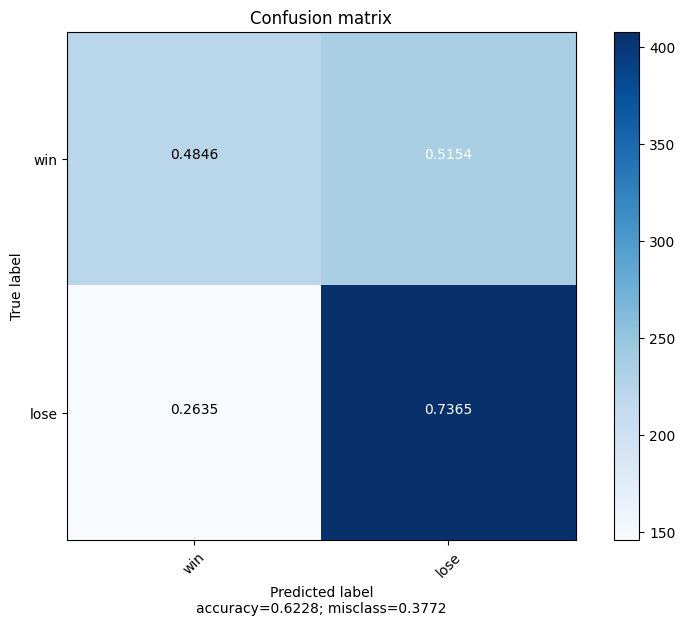

In [25]:
cm = confusion_matrix(test_target, test_preds_binary)
print(cm)
fig = plot_confusion_matrix(cm,['win','lose'])
run["test/confusion_matrix"].upload(fig)


**Test Classification report**

In [26]:
run["test/classification_report"] = classification_report(test_target, test_preds_binary)
print(classification_report(test_target, test_preds_binary))

              precision    recall  f1-score   support

           0       0.60      0.48      0.54       456
           1       0.63      0.74      0.68       554

    accuracy                           0.62      1010
   macro avg       0.62      0.61      0.61      1010
weighted avg       0.62      0.62      0.62      1010



**Test Feature Importance via Shapley values**

For comparison to cross-validation OOF Shapley values to ensure that the model is working in similar manner on the test data as train data

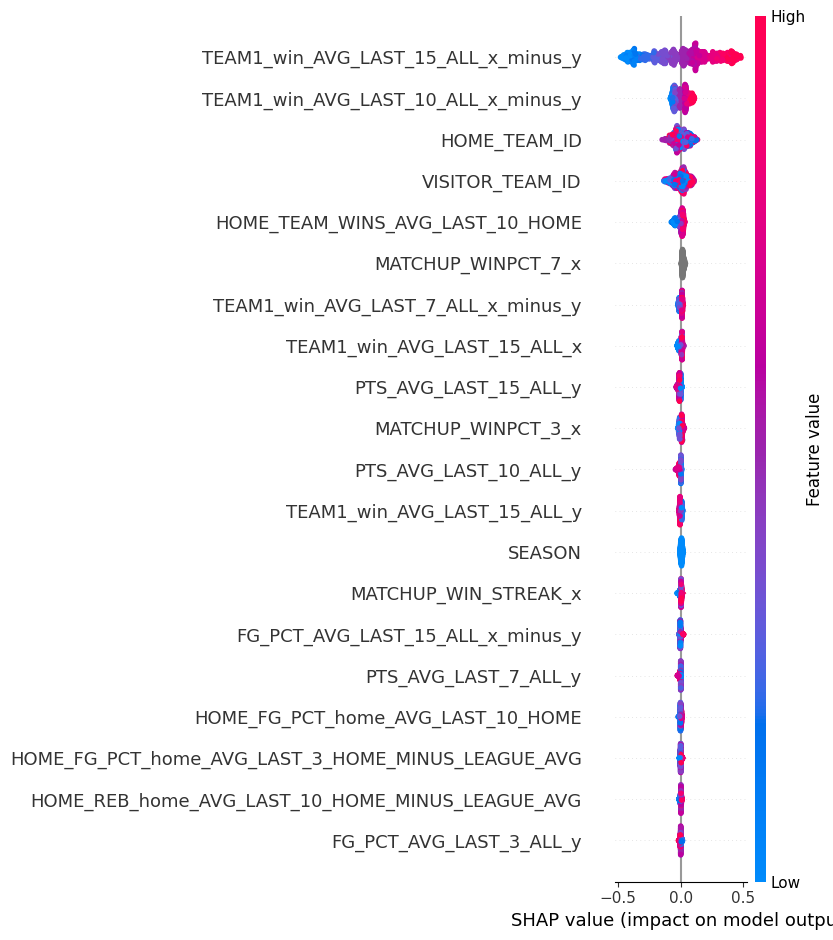

In [27]:
# summarize the effects of all the features
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(test_preds_shap[:,:-1], test)
run["test/shapley_summary"].upload(fig)

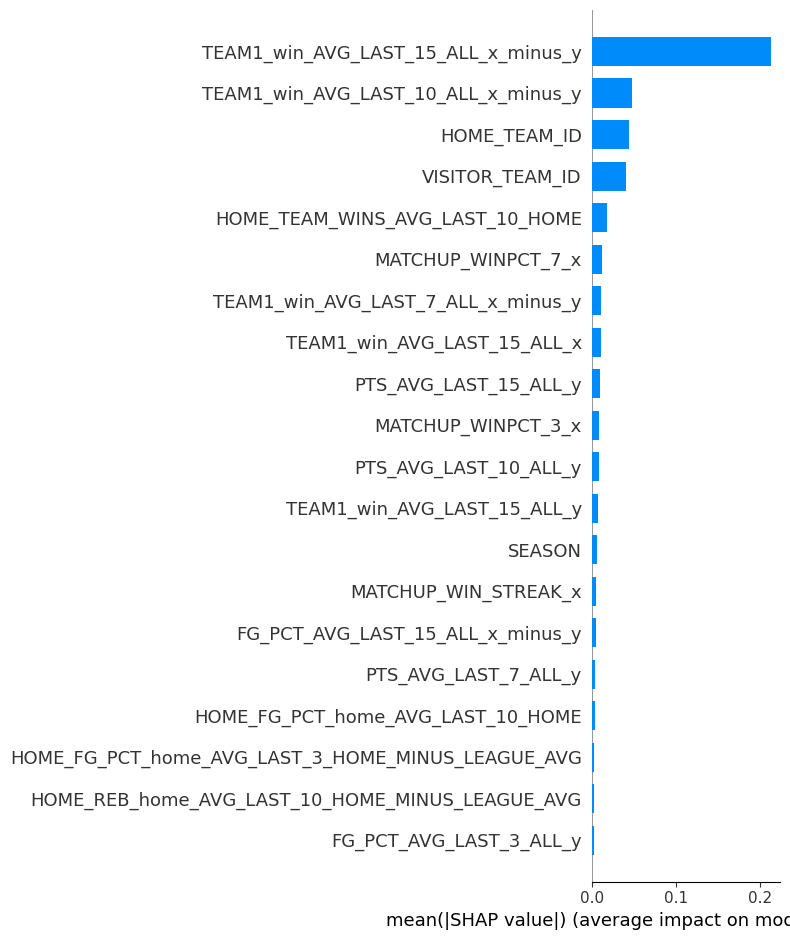

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(test_preds_shap[:,:-1], test[use_columns], plot_type="bar")
run["test/shapley_summary_bar"].upload(fig)

**Save test data with predictions**


In [29]:
test['TARGET'] = test_target
test['PredictionPct'] = test_preds
test['Prediction'] = test_preds_binary
test.to_csv(DATAPATH / "test_predictions.csv",index=False)

## Model Evaluation

 - Compare Simple model predictions vs ML Test data predictions
 - Compare OOF/Train data vs Test/Validation data
 - Compare early season Test data vs later season Test data
 
 Feature importances via Shapley values are *local* to the given dataset and can assist in adversarial validation

**Split Test data**

In [30]:
test = pd.read_csv(DATAPATH / TEST_NAME)
test = fix_datatypes(test)
test = encode_categoricals(test)

SPLIT = pd.to_datetime("2022-01-01")

run["test_split_test1/end_date"] = SPLIT
run["test_split_test2/start_date"] = SPLIT

test1 = test[test['GAME_DATE_EST'] < SPLIT]
test2 = test[test['GAME_DATE_EST'] >= SPLIT]

test1_target = test1['TARGET']
test2_target = test2['TARGET']

test1 = test1[use_columns]
test2 = test2[use_columns]

**Process Splits**

TEST1

Scores:

Accuracy Score: 0.6129032258064516
AUC Score: 0.6515103154107302
Optimal Threshold: 0.5925982820636794
              precision    recall  f1-score   support

           0       0.58      0.58      0.58       241
           1       0.64      0.64      0.64       286

    accuracy                           0.61       527
   macro avg       0.61      0.61      0.61       527
weighted avg       0.61      0.61      0.61       527



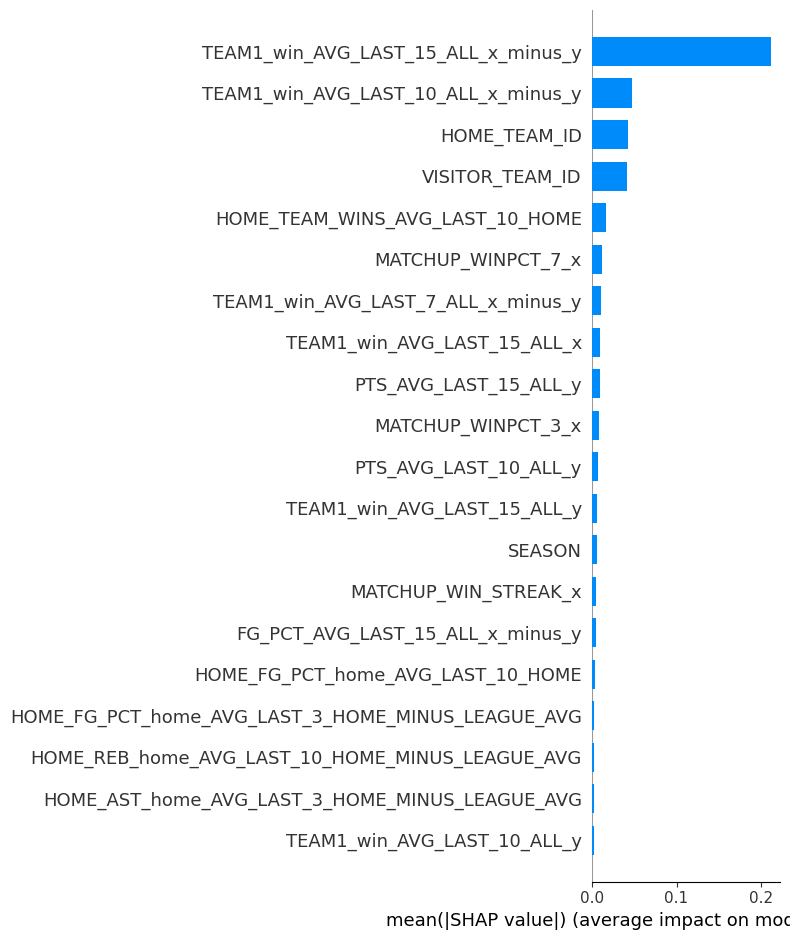

TEST2

Scores:

Accuracy Score: 0.639751552795031
AUC Score: 0.6509371745921555
Optimal Threshold: 0.5426047623806666
              precision    recall  f1-score   support

           0       0.64      0.44      0.52       215
           1       0.64      0.80      0.71       268

    accuracy                           0.64       483
   macro avg       0.64      0.62      0.62       483
weighted avg       0.64      0.64      0.63       483



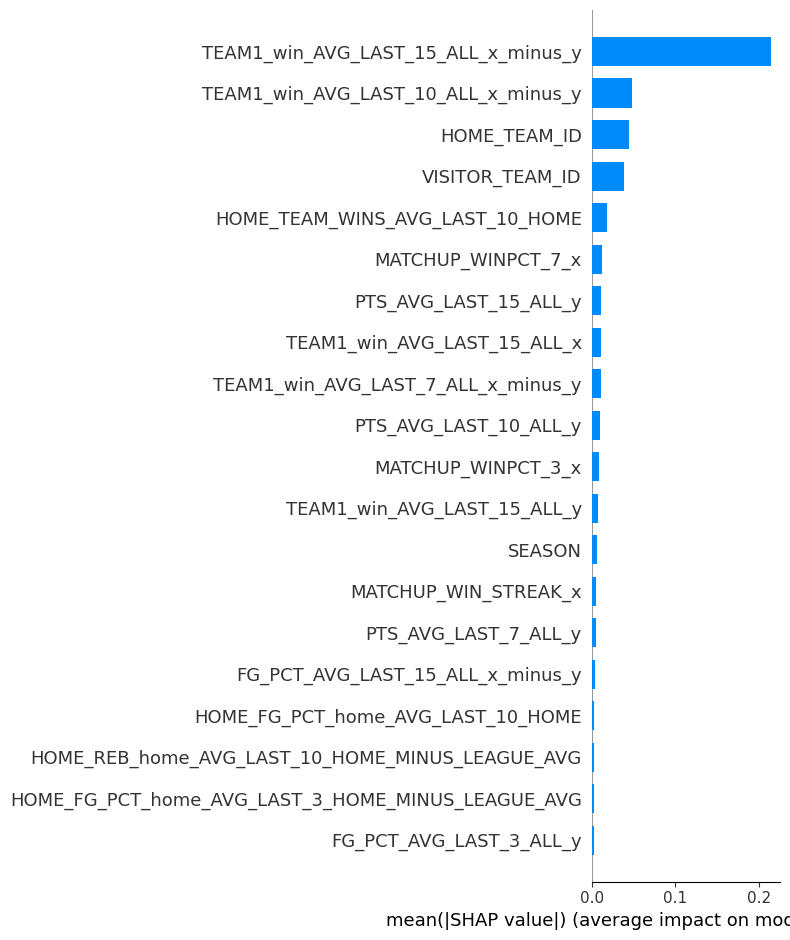

In [31]:
def process_splits(label, test, test_target, results):

    if MODEL_NAME == "xgboost":
        test_data = xgb.DMatrix(test, enable_categorical=ENABLE_CATEGORICAL)
    if MODEL_NAME == "lightgbm":
        test_data = test

    test_preds = model.predict(test_data)
    test_preds_shap = get_shapley(MODEL_NAME, model, test_data)

    test_preds_binary, acc_score, auc_score, optimal_threshold = get_scores(test_target, test_preds)

    run["test_split_" + label + "/accuracy"] = acc_score 
    run["test_split_" + label + "/AUC"] = auc_score 
    run["test_split_" + label + "/optimal_threshold"] = optimal_threshold

    df = {'Label': label, 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':optimal_threshold}
    results = results.append(df, ignore_index = True) 

    run["test_split_" + label + "/classification_report"] = classification_report(test_target, test_preds_binary)
    print(classification_report(test_target, test_preds_binary))
    
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    shap.summary_plot(test_preds_shap[:,:-1], test, plot_type="bar")
    run["test_split_" + label + "/shapley_summary_bar"].upload(fig)

    #Simple model applied to split
    acc_score, auc_score = SimpleModel(test, test_target)
    df = {'Label': 'Simple-' + label, 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
    results = results.append(df, ignore_index = True) 
    
    return test_preds_shap, results
    
print("TEST1")
test_preds_shap1, results = process_splits('Test1',test1, test1_target, results)
print("TEST2")
test_preds_shap2, results = process_splits('Test2',test2, test2_target, results)


**Summary Table**

Key metrics from Simple Model, Train, Test, and Test-split

In [32]:
acc_score1  = results.loc[results['Label'] == 'Train', 'Accuracy'].values[0]
acc_score2  = results.loc[results['Label'] == 'Test', 'Accuracy'].values[0]
acc_score = acc_score1 - acc_score2
auc_score1  = results.loc[results['Label'] == 'Train', 'AUC'].values[0]
auc_score2  = results.loc[results['Label'] == 'Test', 'AUC'].values[0]
auc_score = auc_score1 - auc_score2

df = {'Label': 'Train-Test', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
results = results.append(df, ignore_index = True) 

run["evaluation/train-test_accuracy"] = acc_score
run["evaluation/train-test_AUC"] = auc_score

acc_score1  = results.loc[results['Label'] == 'Test1', 'Accuracy'].values[0]
acc_score2  = results.loc[results['Label'] == 'Test2', 'Accuracy'].values[0]
acc_score = acc_score1 - acc_score2
auc_score1  = results.loc[results['Label'] == 'Test1', 'AUC'].values[0]
auc_score2  = results.loc[results['Label'] == 'Test2', 'AUC'].values[0]
auc_score = auc_score1 - auc_score2

df = {'Label': 'Test1-Test2', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
results = results.append(df, ignore_index = True) 

run["evaluation/test1-test2_accuracy"] = acc_score
run["evaluation/test1-test2_AUC"] = auc_score

run["evaluation/summary_table"].upload(File.as_html(results))
results

,Label,Accuracy,AUC,Threshold
0,Simple Model,0.548515,0.500000,N/A
1,Train,0.649580,0.688630,0.569447
2,Test,0.622772,0.650706,0.564641
3,Test1,0.612903,0.651510,0.592598
4,Simple-Test1,0.542694,0.500000,N/A
5,Test2,0.639752,0.650937,0.542605
6,Simple-Test2,0.554865,0.500000,N/A
7,Train-Test,0.026808,0.037924,N/A
8,Test1-Test2,-0.026848,0.000573,N/A


**Train vs Test Feature Importances via Shapley Values**

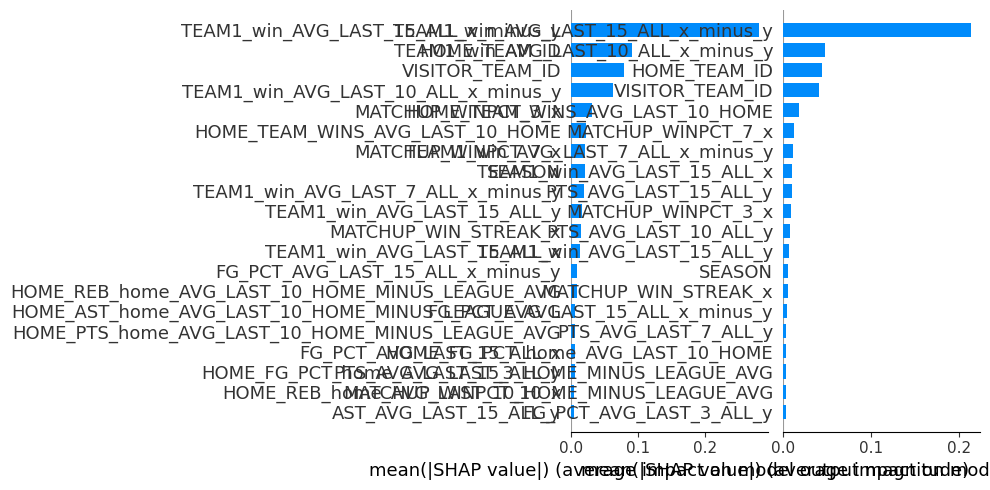

In [33]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar", plot_size=None, show=False)
plt.subplot(1,2,2)
shap.summary_plot(test_preds_shap[:,:-1], test1[use_columns], plot_type="bar", plot_size=None, show=False)
plt.tight_layout()
fig.show()
run["evaluation/test_train_shapley_summary_bar"].upload(fig)

**Test1 vs Test2 Feature Importances via Shapley Values**

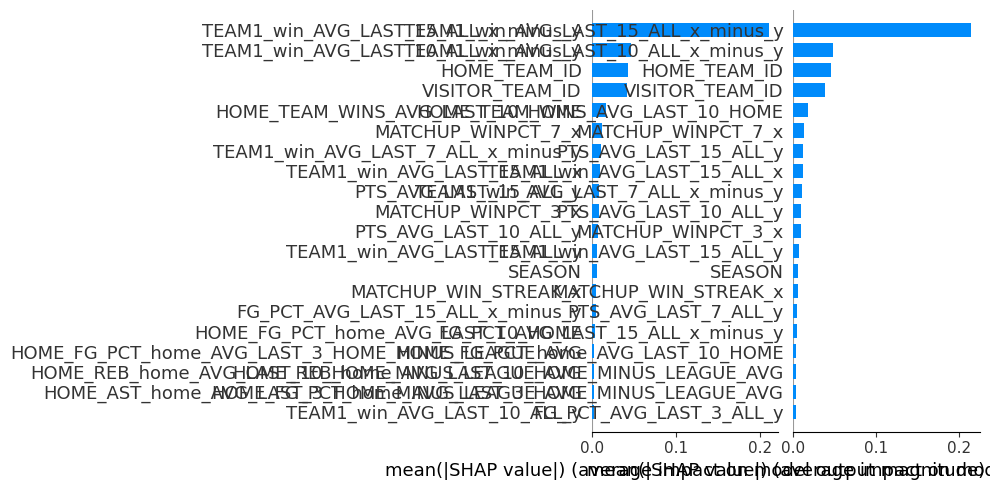

In [34]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
shap.summary_plot(test_preds_shap1[:,:-1], test1[use_columns], plot_type="bar", plot_size=None, show=False)
plt.subplot(1,2,2)
shap.summary_plot(test_preds_shap2[:,:-1], test1[use_columns], plot_type="bar", plot_size=None, show=False)
plt.tight_layout()
fig.show()
run["evaluation/test1_test2_shapley_summary_bar"].upload(fig)

**End experiment tracking**

In [35]:
#end experiment tracking
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 87 operations to synchronize with Neptune. Do not kill this process.
All 87 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/cmunch1/nba-prediction/e/NBAP-77


**Save Tuned Hyperparameters**

Optional function - when run, it overwrites the current "best" hyperparameters with the newly generated hyperparameters. Some descretion is required.

In [38]:
def save_tuned_params(MODEL_NAME, tuned_params):
    with open(MODEL_NAME + '.json', 'w') as f:
        f.write(json.dumps(tuned_params))
        
#save_tuned_params(MODEL_NAME, tuned_params)

**Visualize Data Comparisons**

In [37]:
# run Sweetviz comparing test data that led to a correct prediction vs incorrect prediction

test = pd.read_csv(DATAPATH / 'test_predictions.csv')

test['TARGET'] = test['TARGET'].astype('int8')
test['Prediction'] = test['Prediction'].astype('int8')

test_correct = test[test['TARGET'] == test['Prediction']]
test_wrong = test[test['TARGET'] != test['Prediction']]

#run_sweetviz_comparison(test_correct, 'Test-Correct', test_wrong, 'Test-Wrong', 'Prediction', 'correct-incorrect')

## Notes


**Testing log**

The output for each run is saved at Neptune.ai at the following link: https://app.neptune.ai/cmunch1/nba-prediction/experiments?split=tbl&dash=charts&viewId=979e20ed-e172-4c33-8aae-0b1aa1af3602

**Initial evaluation:**

ML models do perfrom better than the simple "if-then" models so far constructed.

All the models, even the simple model, seems to work better in the latter part of the season (Test1 = early season Test split, Test2 = later season Test split). 

The simple model used was: Home team wins unless they have a losing winning pct. This model as well performed much better on Test2 than on Test1, keying off of winning pct.

This overall trend of better peforamance on Test2 is probably due to "good" teams better distinguishing themselves from "bad" teams as more and more data is accumulated (e.g. good teams winning pct will remain steady or increase as the season goes by, while bad teams winning pct will get smaller and smaller.) 

The key predictions may come to fruition (winning bets) when 2 bad teams play each other and when 2 good teams play each other.

 
**2022-10-29:**

*Limit season-long cumulative features*

As an experiment to try and "tighten" up the differnces between Test1 and Test2, one approach is to limit cumulative data and rely more on shorter term rolling averages. To accomplish this, the following features were removed for some test runs: [ 'G_x', 'W_x', 'L_x', 'W_PCT_x', 'HOME_W_x', 'HOME_L_x', 'HOME_W_PCT_x' , 'ROAD_W_x' , 'ROAD_L_x', 'ROAD_W_PCT_x'] and [ 'G_y', 'W_y', 'L_y', 'W_PCT_y', 'HOME_W_y', 'HOME_L_y', 'HOME_W_PCT_y' , 'ROAD_W_y' , 'ROAD_L_y', 'ROAD_W_PCT_y'] 

As expected, this decreased overall Accuracy and AUC, but it did not really improve variation between Test1 and Test2 either. (Neptune runs NBAP-4 thru 27. The missing runs are failed runs due to code conversion errors when replacing two notebooks with a single notebook.).

The simple model used here was: Home team wins unless thier 3-game home winning pct < 0.5. This did tighten up results between Test1 and Test2 data for the simple model, but did decrease the effectiveness of the simple model in both cases and overall.

**2022-10-30:**

*Include rolling averages from previous season*

Another approach would be to modify features to help the model better determine which teams are "good" or "bad" earlier in the season, and one way to accomplish this is to use data from the previous season. 

While there can be key shake-ups to a teams roster over the off-season due to free-agency, trades, injuries, etc..., a team's success in the previous season can help predict its success in the next season. 

This next test did the following:

 - season-constrained cumulatives were removed again
 - all rolling/expanding averages allowed to stretch back to previous season
 - add rolling/expanding averages for 20 games and 40 games
 
*Test data issues*
 
This did not work well when tested (Neptune run NBAP-29) because the test data (SEASON = 2021) had been split from the other seasons before applying the feature engineering, and the rolling averages had no data to "roll back" to from the previous season.

*Fixed Test data*

To correct this, the last two seasons were temporarily included in the test set just to perform the feature engineering, and once this was complete, the 2nd to last season was deleted from the test set.

*Improved performance*

This modification improved model performance while slighly tightening the AUC scores from Test1 and Test2 (NBAP-31 and 32)

*Re-Tune hyperparameters*

As an experiment, hyperparameters were re-tuned, with tiny improvement (NBAP-33 and 34)

**2022-10-31:**

*Added back season cumulatives*

Season stats were added back in along with the rolling averages that extended back to previous season (NBAP-35 and 36), and performance was slight degraded. More focused feature selection will probably be required but than can wait until all the feature engeering is done.

*Added Home minus Visitor stats*

Subtracted one teams stats from anothers as another means of distinguishing good teams vs bad teams

Not much impact (NBAP-37 and 38)

**2022-11-01 thru 11-06**

*Minus all-team averages*

As another approach to differiantiate teams, subtracted each teams stats from the all-team average for that specific day in time. Various feature selection and modifications (roll lenght) were attempted. See run notes for specifics.




















 





